# Trabalho de ML, Análise de AMES dataset
**Por Pedro Antônio e Felipe Maluli**

In [313]:
import pickle
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Obtendo os dados e processando categóricas.

In [314]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

c:\Users\Pedro Antônio Silva\Desktop\Semestre 4\Machine Learning\proj_1\ames\data


In [315]:
model_data = data.copy()

## Funções para análise de dados

In [316]:
def nonNull_percent(label, null_value = 0 ):
    f = model_data[label] != null_value
    return (model_data[label][f].value_counts().sum()/model_data[label].shape[0] *100)

def heatMapCorr(labels):
    correlation_matrix = model_data[labels + ["SalePrice"]].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

## Copia do processamento feito no notebook 03:
Esse processamento realiza a conversão de features categóricas, sua explicação mais detalhada está contida no Notebook 03. (Realizada por terceiro, Professor Fábio Ayres)

**Trasformação de variáveis não numéricas em dados categóricos ordinais ou binários para indicar o pertencimento a categoria. (feito com pd.get_dummies)**

In [317]:
dumm = []
model_data = data.copy()
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
model_data = pd.get_dummies(model_data, drop_first=True)
model_data.info()
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dumm.append(f'{col}')
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Columns: 166 entries, Lot.Frontage to Exterior_Other
dtypes: bool(2), float64(34), int64(12), uint8(118)
memory usage: 1.4 MB
From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "N

# Feature Engineering

### Abrindo dados como histogramas para checar distribuição.

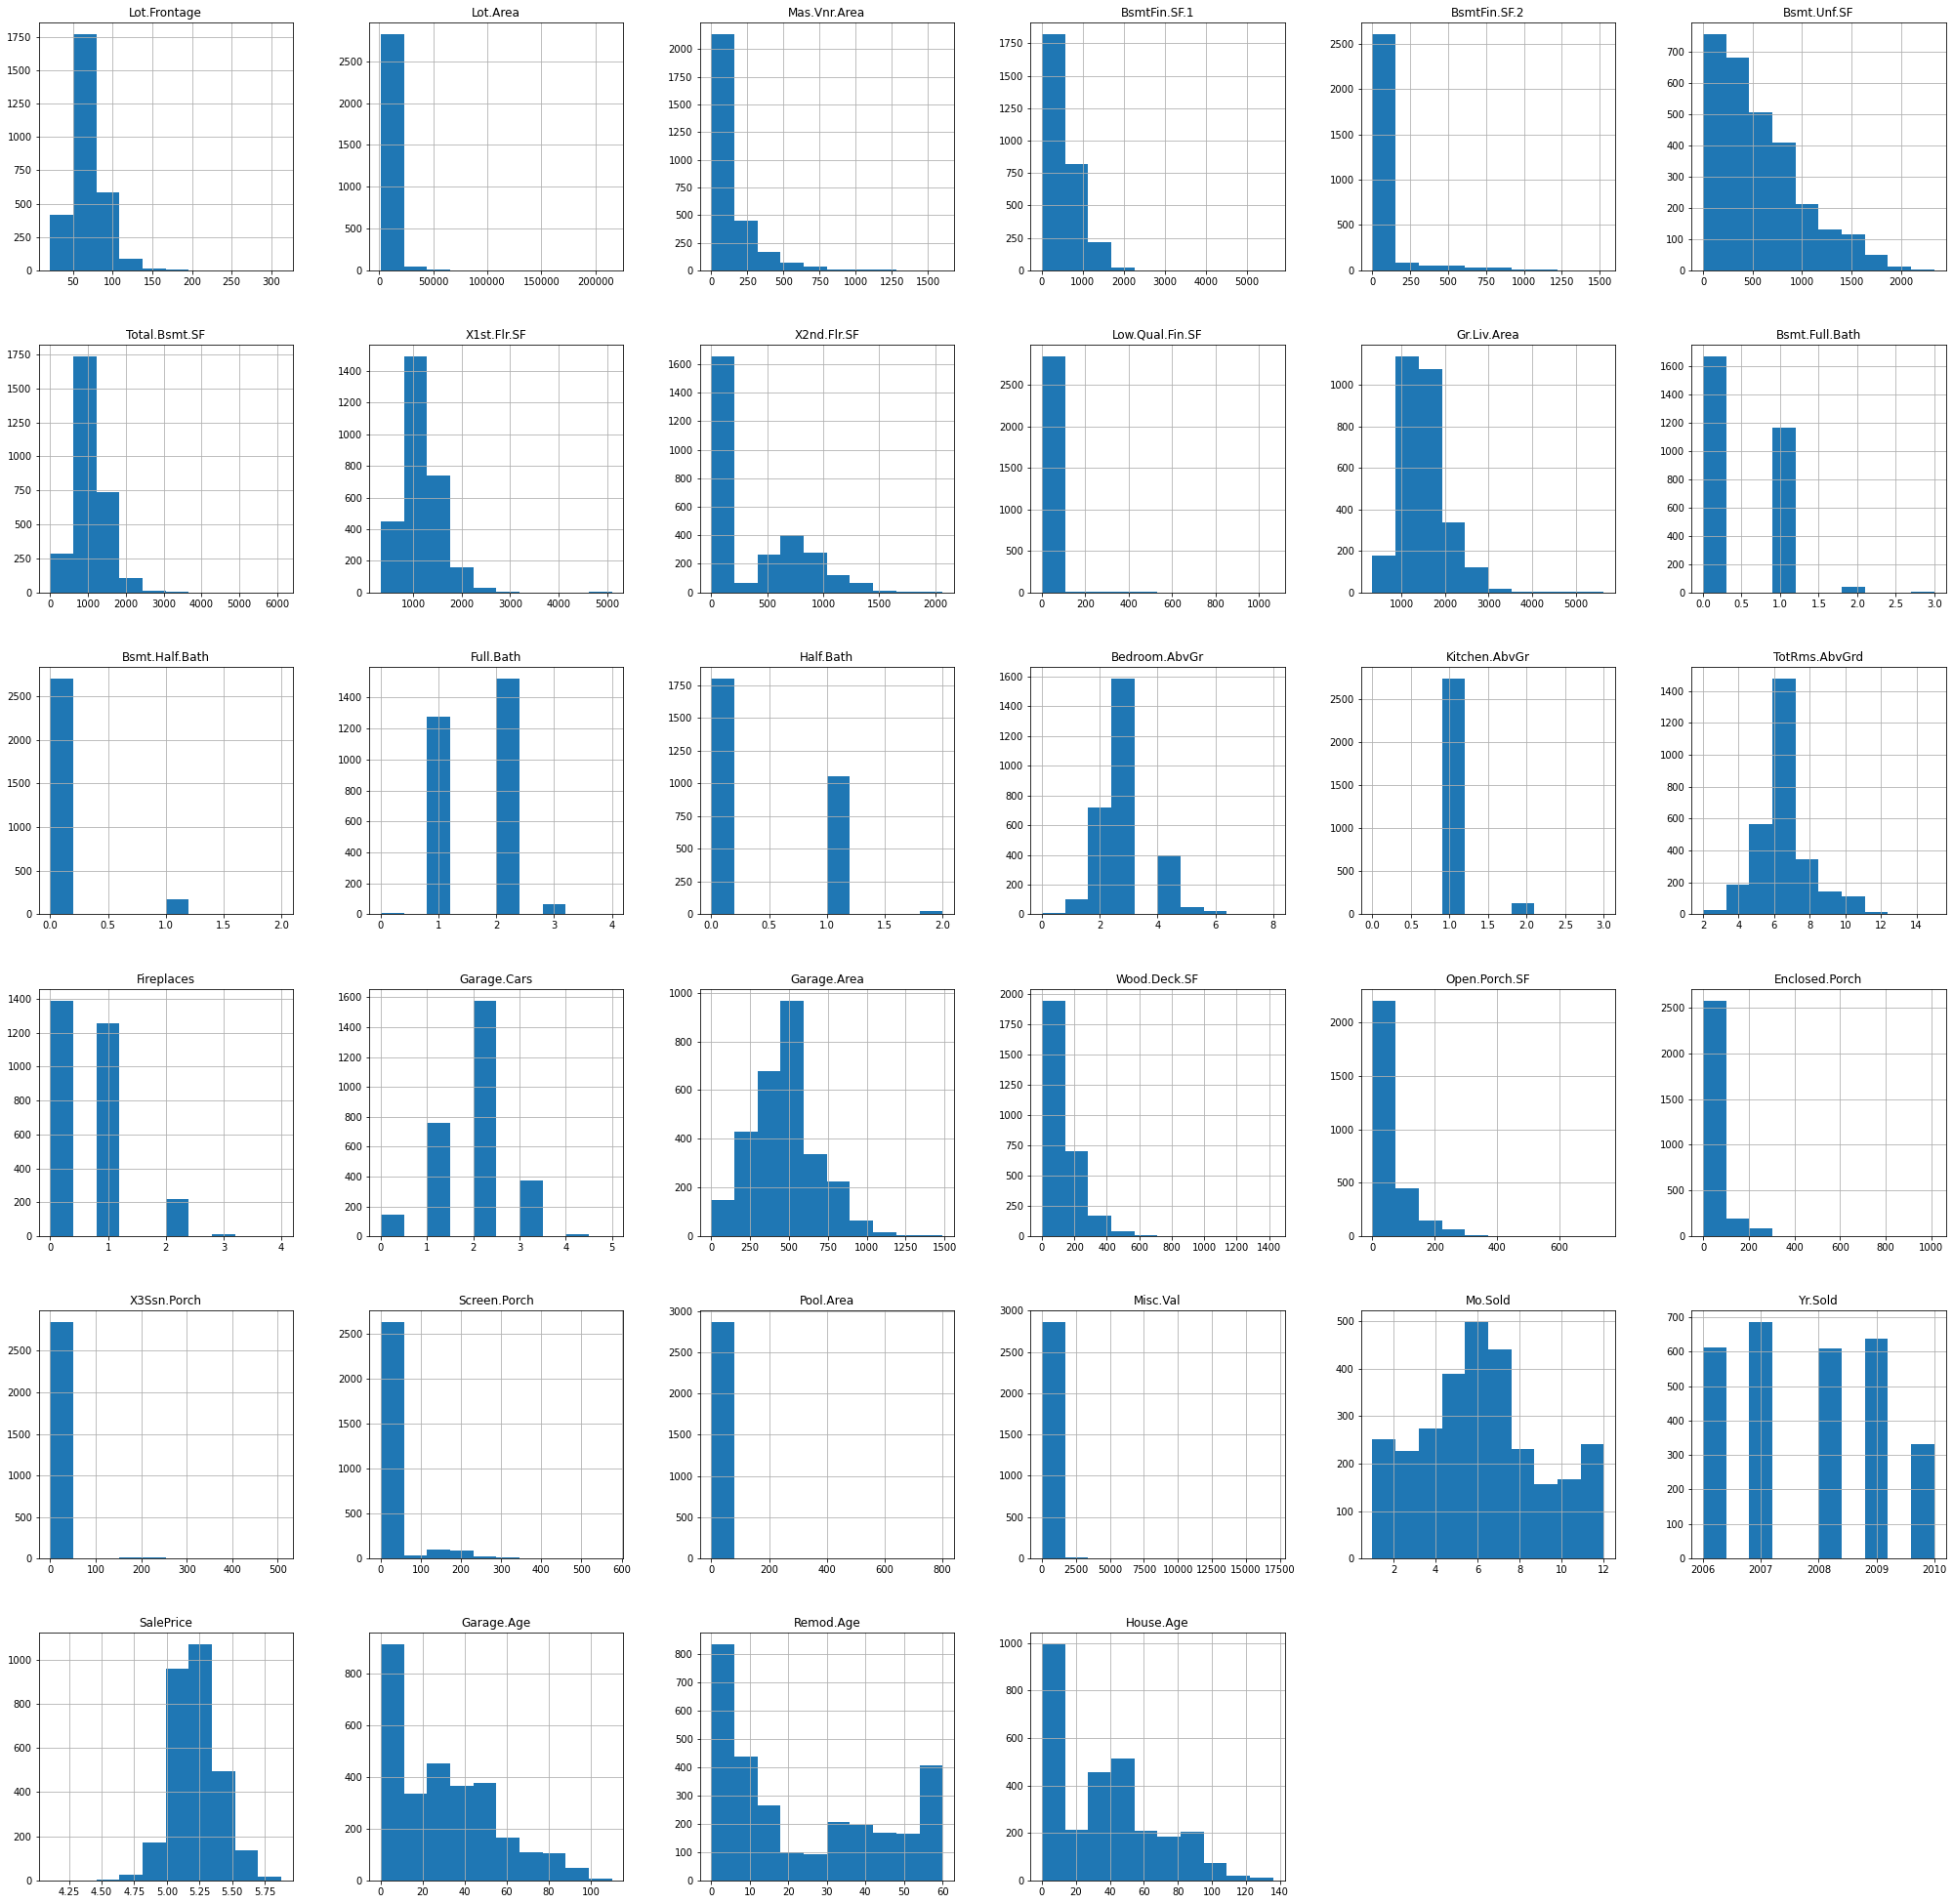

In [318]:
data.hist(figsize=(35,35))
print()

In [319]:
na_list = list(model_data.columns) # inicializando lista que guarda as colunas não analisadas

### Primeiro, checarei variáveis relacionadas ao Lote da casa

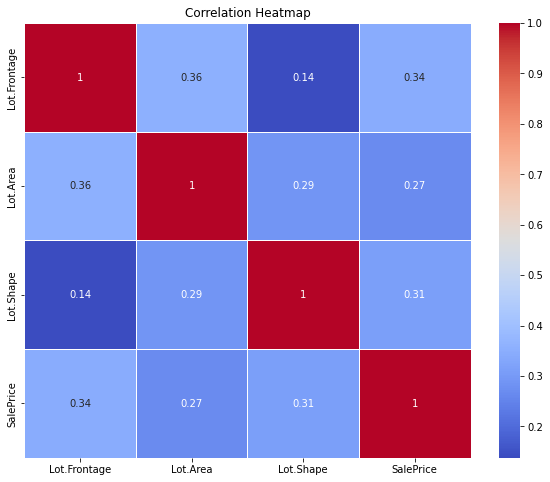

In [320]:
lot_cat = ["Lot.Frontage","Lot.Area","Lot.Shape"]
heatMapCorr(lot_cat)
na_list = [x for x in na_list if x not in lot_cat]

### Todas aparentam ter boa correlação individual com o target, então vamos analisar suas distribuições em busca de melhor representar nossos dados.

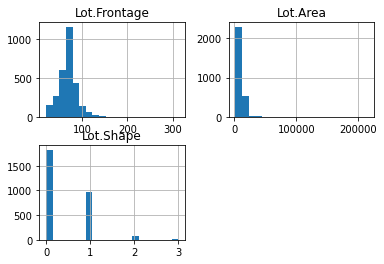

In [321]:
model_data[lot_cat].hist(bins=20)
print()

## Transformação de dados right-skewed em log para melhorar a distribuição dos dados.

Pelo formato do gráfico acima, podemos perceber que os dados de "Lot.Area" tem uma grande quantidade de dados proximos ao zero e conforme a area cresce, a concentração de dados diminui - aplicar uma transformação para log fará nossos dados se tornarem mais legíveis e menos exparsos, mantendo sua propriedade e relevância ao mesmo tempo que os torna mais gaussianos, o que beneficia modelos lineares.

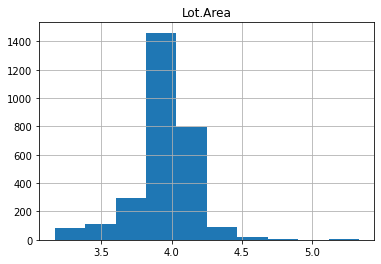

In [322]:
pd.DataFrame(np.log10(data["Lot.Area"])).hist()
print()

OBS: Daqui para frente, dados com esse formato serão armazenados para serem transformados de uma vez só.

## Mas.Vnr.Area

Esse dado aparenta ser de uma feature de dados numéricos não relacionada as outras (numéricas) então será vista separadamente.

0.446062177443733
40.25026068821689


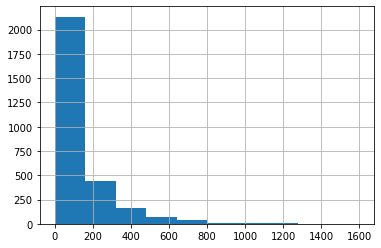

In [323]:
print(model_data[["Mas.Vnr.Area","SalePrice"]].corr()["SalePrice"][0]) # high correlation...
model_data["Mas.Vnr.Area"].hist()
print(nonNull_percent("Mas.Vnr.Area")) # has a good non-null amount...
right_skewed = []
na_list.remove("Mas.Vnr.Area")

Como sua correlação e valores não-nulos são altos, vamos mante-la. Além disso, é right-skewed. Por isso, vamos aplicar um log mais a frente.

In [324]:
right_skewed.append("Mas.Vnr.Area")

## Analysing Exter attributes

Essas features delimitam uma avaliação/ordem crescente e avaliam dados da mesma área, então criar uma feature generalizada pode nos ajudar a remover redundancia dos dados.

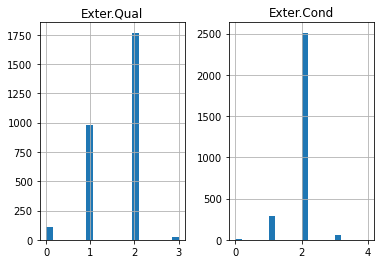

In [325]:
# External features
exter_cat = ["Exter.Qual","Exter.Cond"]
model_data[exter_cat].hist(bins=20) # these seem to reflect a more umbalanced rating
print()
na_list = [x for x in na_list if x not in exter_cat]

Além disso, podemos verificar atráves dos histogramas que a feature criada tem comportamento similar ao de seus componentes e melhora a distribuição dos dados.

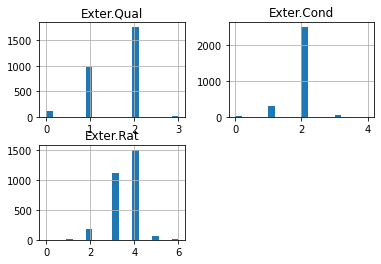

In [326]:
model_data["Exter.Rat"] = model_data["Exter.Qual"] + model_data["Exter.Cond"]
model_data[exter_cat+["Exter.Rat"]].hist(bins=20)
model_data = model_data.drop(columns=exter_cat)

## Dados de Área do Porão

### Verificaremos dados referentes a área do porão em conjunto

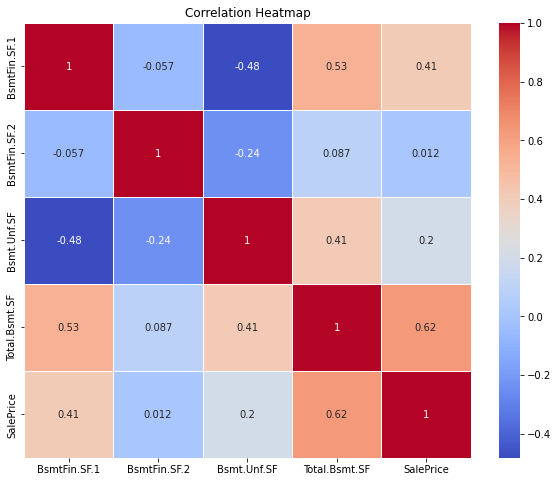

In [327]:
# Basement Features (Area)
basement_cat = ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF","Total.Bsmt.SF"]
heatMapCorr(basement_cat) # checking relevance...
na_list = [x for x in na_list if x not in basement_cat]

#### Podemos verificar que todas essas areas são relevantes, exceto por "BsmtFin.SF.2", com correlação de quase 1%
portanto, removeremos ele e checaremos o formato das demais.

BsmtFin.SF.1 68.57838025721237
BsmtFin.SF.2 12.02641640597845
Bsmt.Unf.SF 91.83176920403197
Total.Bsmt.SF 97.46263468891206


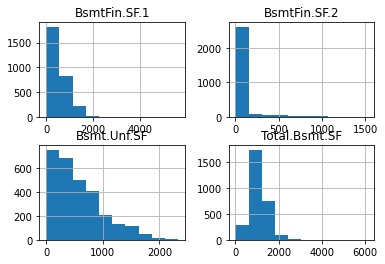

In [328]:
model_data[basement_cat].hist()
for cat in basement_cat:
    print(cat, nonNull_percent(cat))

model_data = model_data.drop(columns='BsmtFin.SF.2')

#### Dos dados restantes, 'BsmtFin.SF.2' e "Bsmt.Unf.SF" são right-skewed

In [329]:
right_skewed += ["BsmtFin.SF.1", "Bsmt.Unf.SF"]

## Features de Aquecimento e Eletricidade

Vericaremos a correlação entre as features e o target para decidir se vale a pena criar uma feature generalizada.

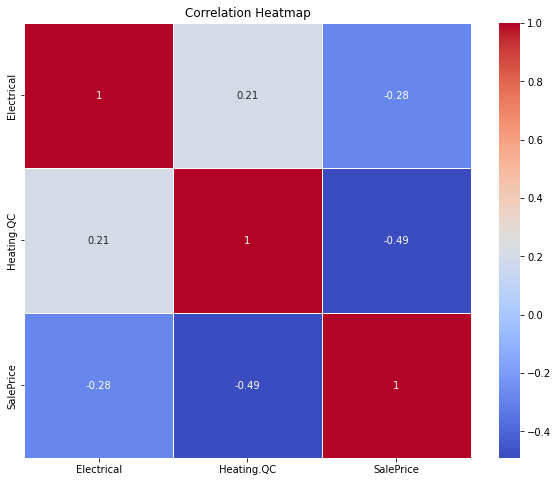

In [330]:
# Heating and Eletrical categories
he_cat = ["Electrical","Heating.QC"]
heatMapCorr(he_cat)  # seems relevant enough
na_list = [x for x in na_list if x not in he_cat]

A correlação das features com target é alta, porém a correlação entre elas nem tanto, além de serem de sistemas diferentes, portanto não vamos criar uma feature generalizada porque há potencial de perdermos informação.

8.168230795968022
48.348974626346894


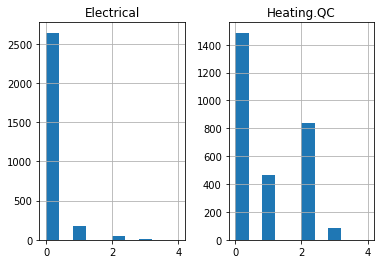

In [331]:
model_data[he_cat].hist()
print(nonNull_percent(he_cat[0]))
print(nonNull_percent(he_cat[1]))

Vimos que de apenas 8.16% são não-nulos para a feature "Electrical", então podemos considerar a remoção dessa feature.

Ao considerar a remoção da feature, devemos analisar a correlação entre as features e o target para decidir se vale a pena. 

Como a correlação é razoavelmente alta(-0.28) para tantos valores comuns, conseguimos interpretar que os poucos dados não-comuns da feature como dados relevantes para o target. Portanto, manteremos a feature. 

## Xcat Features

### Checando correlação

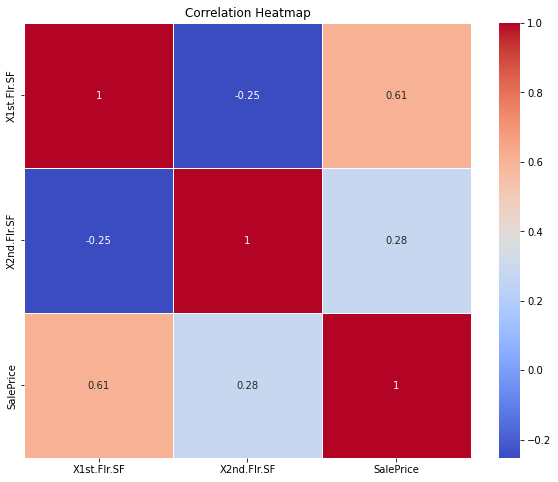

In [332]:
# xcat features
xcat = ["X1st.Flr.SF","X2nd.Flr.SF"] 
heatMapCorr(xcat)
na_list = [x for x in na_list if x not in xcat]

A correlação entre as features isoladas tem relevância alta, apesar de serem dados aparentemente relacionados, não vamos criar uma feature generalizada porque há potencial de perdermos informação.

Vamos checar a quantidade de valores não comuns da feature 'X2ndFlrSF' para auxiliar na análise do histograma.

In [333]:
print(nonNull_percent(xcat[1]))

42.75286757038582


Checando os histogramas para decidir se é preciso transformar os dados.

array([[<AxesSubplot:title={'center':'X1st.Flr.SF'}>,
        <AxesSubplot:title={'center':'X2nd.Flr.SF'}>]], dtype=object)

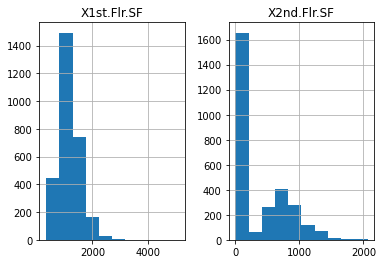

In [334]:
model_data[xcat].hist()

Como X2nd parece ser right-skewed, poderemos transformar os dados em log para melhorar sua distribuição.

In [335]:
right_skewed.append(xcat[1])

## Análise da Feature Low.Qual.Fin.SF

Esse dado aparenta ser de uma feature de dados numéricos não relacionada as outras (numéricas) então será vista separadamente.

Abaixo estamos verificando a correlação da feature com o target e quantidade de non-null values para ver se vale a pena manter a feature.

In [336]:
print(model_data[["Low.Qual.Fin.SF","SalePrice"]].corr()["SalePrice"][0])
nonNull_percent("Low.Qual.Fin.SF")
na_list.remove("Low.Qual.Fin.SF")

-0.04297306856416149


Como ambos são baixos, removeremos a feature.

In [337]:
model_data = model_data.drop(columns="Low.Qual.Fin.SF")

## Aprimoramento das Features de Cômodos e Area Quadradada de Habitação

##### Com as informações de "Gr.Liv.Area" e o numero total de quartos, podemos obter o tamanho médio de cada cômodo da casa (SqFtPerRoom), o que será um delimitador importante, visto que pondera varias medidas muito correlatas ao target, podendo ajudar a distiguir entre elas. Essas features serão mantidas por razões contextuais e por suas correlações isoladas serem altas.

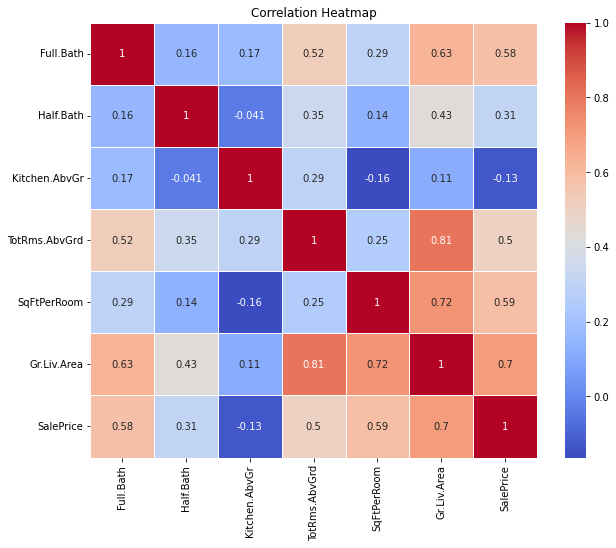

In [338]:
rooms = ["Full.Bath","Half.Bath", "Kitchen.AbvGr", "TotRms.AbvGrd"]
model_data["SqFtPerRoom"] =  model_data["Gr.Liv.Area"] / (model_data["TotRms.AbvGrd"] +
                                                       model_data["Full.Bath"] +
                                                       model_data["Half.Bath"] +
                                                       model_data["Kitchen.AbvGr"])
heatMapCorr(rooms+["SqFtPerRoom","Gr.Liv.Area"])
print()

na_list = [x for x in na_list if x not in rooms+["SqFtPerRoom","Gr.Liv.Area"]]

## Features da Area de Porch/Varanda

Análise de correlação.

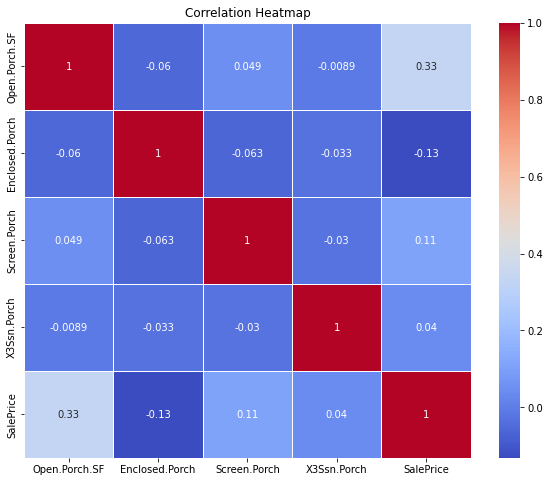

In [339]:
porch_cat = ["Open.Porch.SF","Enclosed.Porch", "Screen.Porch", "X3Ssn.Porch"]
heatMapCorr(porch_cat)
na_list = [x for x in na_list if x not in porch_cat]

Como a correlação é baixa para todos menos o Open.Porch.SF, consideraremos a remoção das features se a quantidade de valores não nulos também for baixa. 

Faremos uma feature generalizada para ver se conseguimos melhorar a correlação e reduzir o numero de valores nulos, como estamos tratando de área, removeremos todas as outras se esta ultima for melhor.

In [340]:
model_data['Total.Porch.SF'] = model_data['Open.Porch.SF'] + model_data['Enclosed.Porch'] + model_data['Screen.Porch'] + model_data['X3Ssn.Porch']

Mais uma vez, veremos o heatmap, dessa vez com a feature generalizada para ver se conseguimos melhorar a correlação.

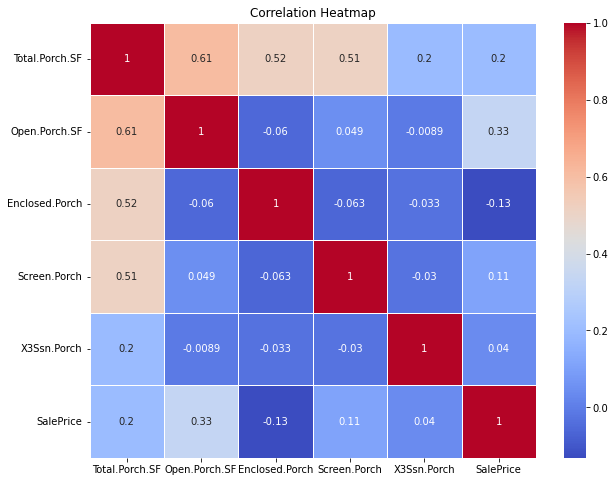

In [341]:
heatMapCorr(['Total.Porch.SF']+porch_cat)

Checando para valores nulos e distrubuição de dados.

55.89155370177268
15.363225582203684
8.86339937434828
1.251303441084463


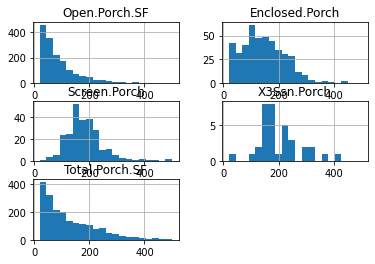

In [342]:
model_data[porch_cat+['Total.Porch.SF']].hist(bins=20,range=(20,500))

for cat in porch_cat:
    print(nonNull_percent(cat))

Como o total porch se assemelha com Open.Porch.SF e é uma combinação de features, apesar de abaixar a correlação um pouco, decidimos manter somente o Total.Porch.SF, pois representa nossos dados de forma mais ampla retendo o comportamento esperado da feature mais relevante das quais é composto.

In [343]:
model_data = model_data.drop(columns=porch_cat)

Além disso, como Total.Porch.SF é right-skewed, podemos transformar os dados em log para melhorar a distribuição dos dados.

In [344]:
right_skewed.append("Total.Porch.SF")

## Análise de Features que Aparentam ser Redundantes ou Isoladas

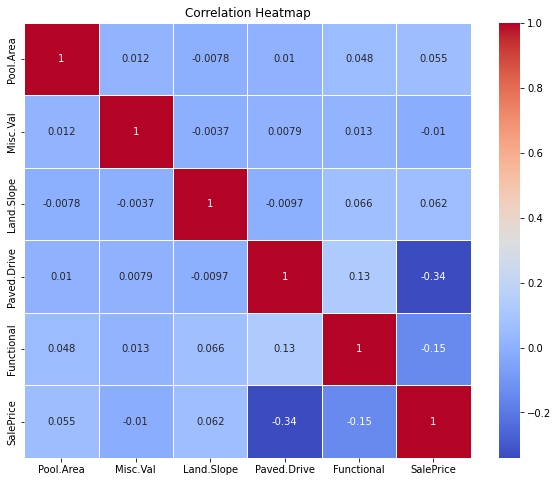

In [345]:
heatMapCorr(["Pool.Area","Misc.Val","Land.Slope","Paved.Drive","Functional"])
na_list = [x for x in na_list if x not in ["Pool.Area","Misc.Val","Land.Slope","Paved.Drive","Functional"]]

Como quase todas as features tem baixíssima correlação, removeremos todas menos "Paved.Drive" e "Functional", que analisaremos mais a fundo.

In [346]:
model_data = model_data.drop(columns=["Pool.Area","Misc.Val","Land.Slope"])

# Agora analisando as colunas que sobraram
print(nonNull_percent("Paved.Drive"))
print(nonNull_percent("Functional"))

8.932916232186304
6.777893639207508


Como a correlação é considerável, e a quantidade de non-null values é baixa, esses non-null values podem ser considerados como dados relevantes para o target. Portanto, manteremos as features.

## Overall Quality and Condition

##### Unificação das avaliações, como foi feito com Ext.Qual e Cond.

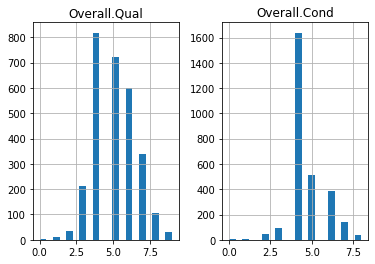

In [347]:
# Overall Quality and Condition
overall_cat = ["Overall.Qual","Overall.Cond"]
model_data[overall_cat].hist(bins=20) # these seem to reflect a more umbalanced rating
print()
na_list = [x for x in na_list if x not in overall_cat]

array([[<AxesSubplot:title={'center':'Overall.Qual'}>,
        <AxesSubplot:title={'center':'Overall.Cond'}>],
       [<AxesSubplot:title={'center':'Overall.Rat'}>, <AxesSubplot:>]],
      dtype=object)

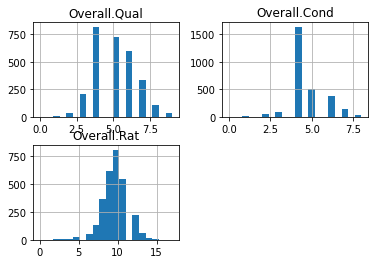

In [348]:
model_data["Overall.Rat"] = model_data["Overall.Qual"] + model_data["Overall.Cond"]
model_data[overall_cat+["Overall.Rat"]].hist(bins=20)

In [349]:
model_data = model_data.drop(columns=overall_cat)

## Verificando Features que Ainda Não Foram Analisadas

In [350]:
naList_nd = [i for i in na_list if i not in dumm]
naList_d = [i for i in na_list if i in dumm]

remaining non-dummy features



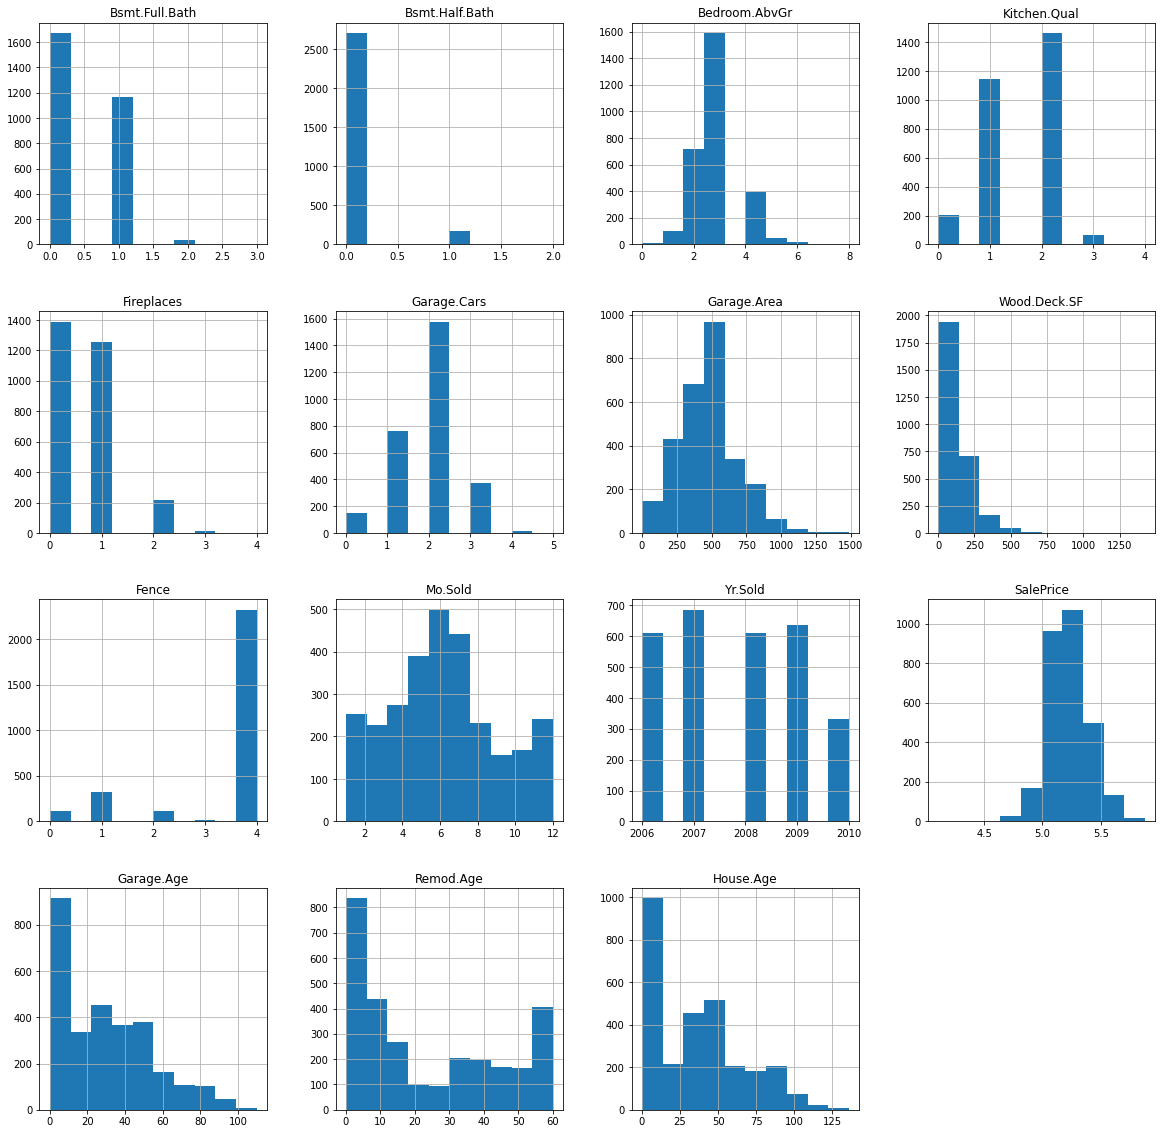

In [351]:
print("remaining non-dummy features")
model_data[naList_nd].hist(figsize=(20,20))
print()

## Features de Garagem

array([[<AxesSubplot:title={'center':'Garage.Cars'}>,
        <AxesSubplot:title={'center':'Garage.Area'}>]], dtype=object)

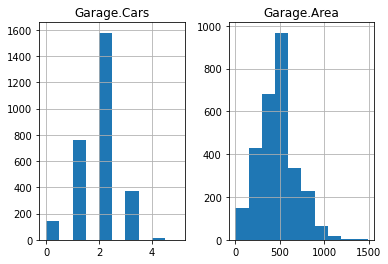

In [352]:
gar_cat = ["Garage.Cars","Garage.Area"]
model_data[gar_cat].hist(bins=10)

Como são parecidos e tem relação contextual, vamos tentar criar uma feature generalizada.

<AxesSubplot:>

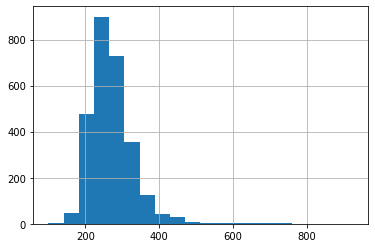

In [353]:
model_data["FtPerCar"] = model_data["Garage.Area"] / model_data["Garage.Cars"]
model_data["FtPerCar"].hist(bins=20)

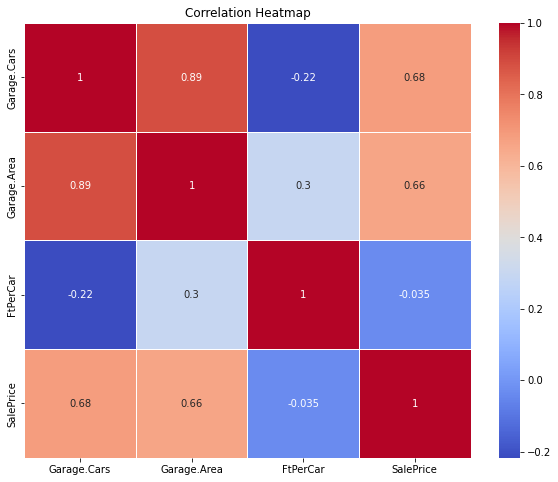

In [354]:
heatMapCorr(gar_cat + ["FtPerCar"])
na_list = [x for x in na_list if x not in gar_cat]

Como a correlação de "Garage.Cars" e "Garage.Area" é alta, e a de "FtPerCar" é baixa, vamos remover "FtPerCar", e manter as outras duas, já que aparetemente essa relação entre features não é o que as dá relevância.

In [355]:
model_data = model_data.drop(columns=["FtPerCar"])
print()

## Features Restantes da Casa

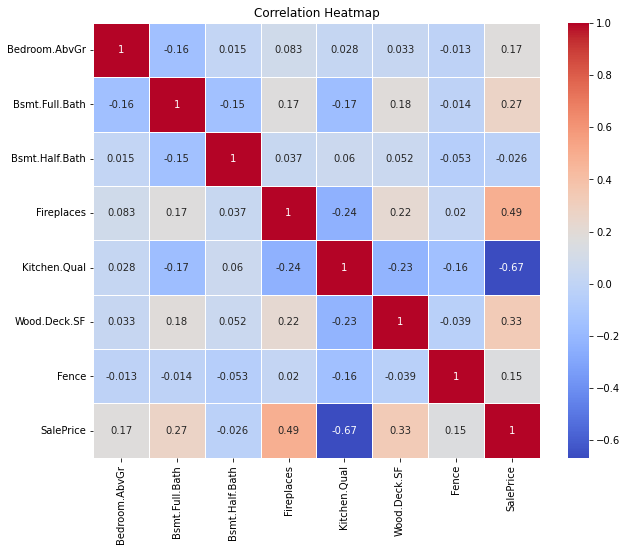

In [356]:
restantes = ["Bedroom.AbvGr","Bsmt.Full.Bath","Bsmt.Half.Bath", "Fireplaces", "Kitchen.Qual","Wood.Deck.SF","Fence"]
heatMapCorr(restantes)

Como o Bsmt.Half.Bath tem uma correlação baixa, e o Bsmt.Full.Bath tem uma correlação alta, vamos tentar combinar o Bsmt.Half.Bath com o Bsmt.Full.Bath para criar uma feature generalizada.

In [357]:
model_data['Bsmt.Total.Baths'] = model_data['Bsmt.Full.Bath'] + model_data['Bsmt.Half.Bath']

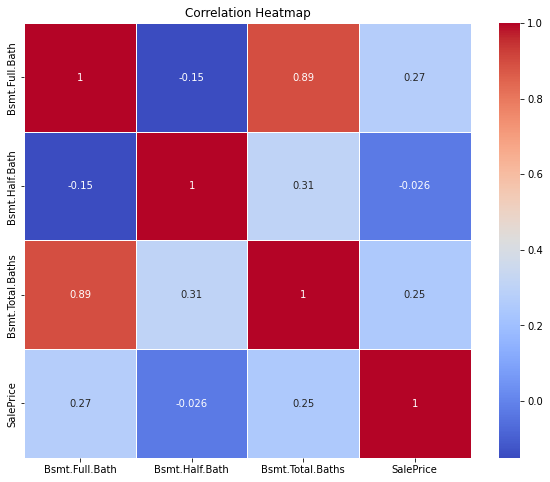

In [358]:
heatMapCorr(['Bsmt.Full.Bath', 'Bsmt.Half.Bath','Bsmt.Total.Baths'])

Ficando somente com o Bsmt.Total.Baths, perdemos pouca correlação, e ganhamos uma feature generalizada que compacta bem a informação.

In [359]:
model_data = model_data.drop(columns=['Bsmt.Full.Bath', 'Bsmt.Half.Bath'])
print()

Dados vistos no histograma ou heatmap e não mencionados serão mantidos, tanto por não terem comportamento irregular quanto por representarem dados em medidas nas quais aplicar uma transformação pode descaracterizar nossos dados.

## Análise de Dummy features

Esses dados representam features com multiplas categorias não ordenais.

remaining dummy features


array([[<AxesSubplot:title={'center':'MS.SubClass_30'}>,
        <AxesSubplot:title={'center':'MS.SubClass_50'}>,
        <AxesSubplot:title={'center':'MS.SubClass_60'}>,
        <AxesSubplot:title={'center':'MS.SubClass_70'}>,
        <AxesSubplot:title={'center':'MS.SubClass_80'}>,
        <AxesSubplot:title={'center':'MS.SubClass_85'}>,
        <AxesSubplot:title={'center':'MS.SubClass_90'}>,
        <AxesSubplot:title={'center':'MS.SubClass_120'}>,
        <AxesSubplot:title={'center':'MS.SubClass_160'}>,
        <AxesSubplot:title={'center':'MS.SubClass_190'}>,
        <AxesSubplot:title={'center':'MS.SubClass_Other'}>],
       [<AxesSubplot:title={'center':'MS.Zoning_RH'}>,
        <AxesSubplot:title={'center':'MS.Zoning_RL'}>,
        <AxesSubplot:title={'center':'MS.Zoning_RM'}>,
        <AxesSubplot:title={'center':'Land.Contour_HLS'}>,
        <AxesSubplot:title={'center':'Land.Contour_Low'}>,
        <AxesSubplot:title={'center':'Land.Contour_Lvl'}>,
        <AxesSubplot:tit

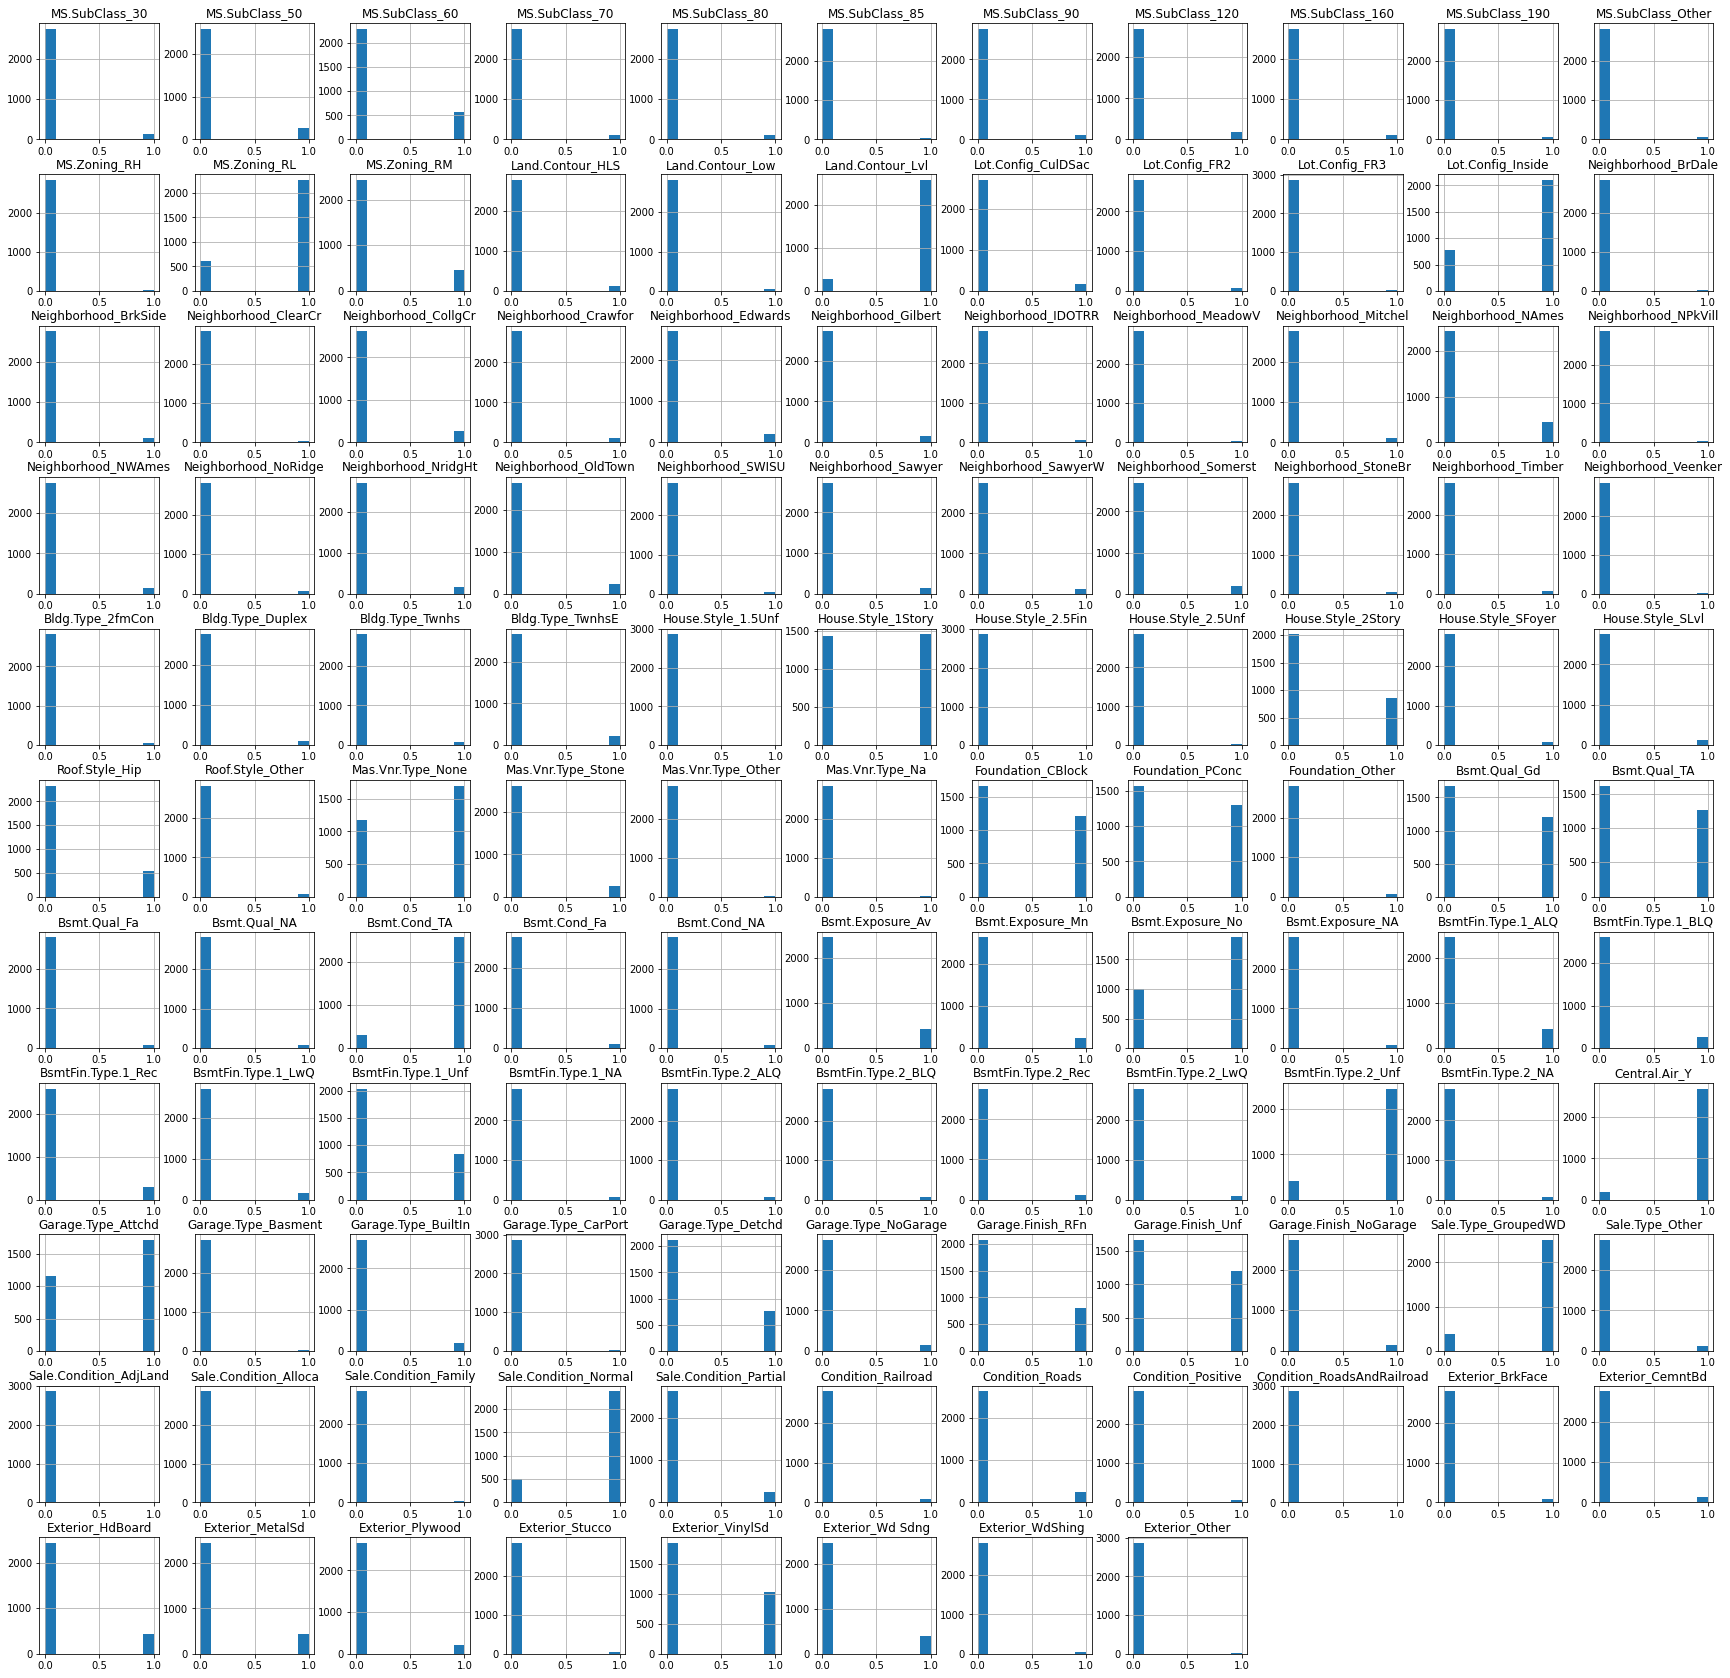

In [360]:
# Exige bastante do computador, rodar a próprio risco
print("remaining dummy features")
# model_data[naList_d].hist(figsize=(30,30))

## Análise Features categóricas não-ordinais

#### Caso seja redundate a categoria será removida.



Não possuir "Vnr" já é indicado pela medida de Área análisada previamente, de resto os dados tem baixa correlação, apesar de conjuntamente capazes de impactar o resultado, o motivo de serem mantidos

In [306]:
model_data = model_data.drop(columns="Mas.Vnr.Type_None")

Pelo mesmo motivo, "Garage.Type_NoGarage" será removido:

In [ ]:
model_data = model_data.drop(columns="Garage.Type_NoGarage")

##### OBS: Outras alterações não foram feitas, principalmente para que os modelos análisados possam utilizar suas propriedades de forma mais aparente.

## Transformação de dados Right-skewed

Aplicaremos o log1p do numpy para tornarmos a distribuição de dados mais gaussiana e nossos valores nulos deslocados do restante. Expicado em mais detalhes anteriormente.

array([[<AxesSubplot:title={'center':'Mas.Vnr.Area'}>,
        <AxesSubplot:title={'center':'BsmtFin.SF.1'}>],
       [<AxesSubplot:title={'center':'Bsmt.Unf.SF'}>,
        <AxesSubplot:title={'center':'X2nd.Flr.SF'}>],
       [<AxesSubplot:title={'center':'Total.Porch.SF'}>, <AxesSubplot:>]],
      dtype=object)

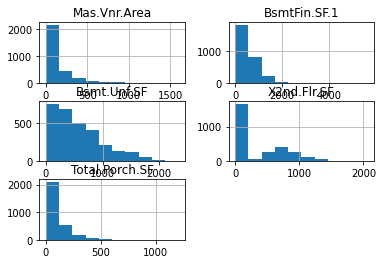

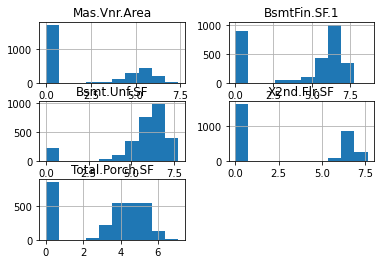

In [362]:
model_data[right_skewed].hist()
model_data[right_skewed] = np.log1p(model_data[right_skewed])
model_data[right_skewed].hist()

# Modelos

Vamos utilizar os seguintes modelos preditivos: Liner Regression, Ridge, Lasso, XgBoost e CatBoost

**Será feita a separação train-test para todos os modelos**

In [88]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [363]:
y = model_data["SalePrice"].copy()
X = model_data.drop(columns=["SalePrice"]).copy()
        
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=12,)
error_percent = {"LinearRegression":0,"Ridge":0,"Lasso":0}

## Linear Regression

Utilizaremos a pipeline com Polynomial features e Standard Scaler para este modelo.

In [364]:
piped_linear = Pipeline([
    ("Polynomial",PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Linear", LinearRegression()),
])

param_grid_linear = {
    'Polynomial__degree': [0,1,2],
}

grid_search_linear = GridSearchCV(piped_linear, param_grid_linear, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_linear.fit(Xtrain,ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Polynomial', PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Linear', LinearRegression())]),
             param_grid={'Polynomial__degree': [0, 1, 2]},
             scoring='neg_mean_squared_error')

In [ ]:
print(f'melhores parametros para Linear Regression: {grid_search_linear.best_params_}')
score_linear = cross_val_score(grid_search_linear.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_linear = np.sqrt(-score_linear)
print(f'RMSE: {list(score_linear)}')
error_percent_linear = 100 * (10**score_linear - 1)

error_percent["LinearRegression"] = error_percent_linear
print(f'erro percentual: {list(error_percent["LinearRegression"])}')

melhores parametros para Linear Regression: {'Polynomial__degree': 0}
RMSE: [0.165713118458037, 0.18035322296263231, 0.17169509155849005, 0.1707859092467859, 0.17962224099284665]
erro percentual: [46.45800649234633, 51.479276778899454, 48.489276624255375, 48.178743990843806, 51.224529157979305]


## Ridge

Utilizaremos a pipeline com Polynomial features e Standard Scaler para este modelo.

In [ ]:
piped_ridge = Pipeline([
    ("Polynomial",PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Ridge", Ridge())
])

param_grid_ridge = {
    'Ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'Polynomial__degree': [0,1,2],
}

grid_search_ridge = GridSearchCV(piped_ridge, param_grid_ridge, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_ridge.fit(Xtrain,ytrain)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Polynomial', PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Ridge', Ridge())]),
             param_grid={'Polynomial__degree': [0, 1, 2],
                         'Ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring='neg_mean_squared_error')

In [ ]:
print(f'melhores parametros para Ridge Regression: {grid_search_ridge.best_params_}')
score_ridge = cross_val_score(grid_search_ridge.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_ridge = np.sqrt(-score_ridge)
print(f'RMSE: {list(score_ridge)}')
error_percent_ridge = 100 * (10**score_ridge - 1)
error_percent["Ridge"] = error_percent_ridge
print(f'erro percentual: {list(error_percent["Ridge"])}')

melhores parametros para Ridge Regression: {'Polynomial__degree': 1, 'Ridge__alpha': 10.0}
RMSE: [0.046393325939765834, 0.055688596483162336, 0.057256689467549915, 0.051694291753605785, 0.053530800367690534]
erro percentual: [11.273904147997316, 13.681186178678463, 14.092393065355257, 12.640427938544118, 13.117761013396345]


## Lasso

Utilizaremos a pipeline com Polynomial features e Standard Scaler para este modelo.

In [ ]:
piped_lasso = Pipeline([
    ("Polynomial",PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Lasso", Lasso())
])

param_grid_lasso = {
    'Lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'Polynomial__degree': [0,1,2],
}

grid_search_lasso = GridSearchCV(piped_lasso, param_grid_lasso, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_lasso.fit(Xtrain,ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Polynomial', PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Lasso', Lasso())]),
             param_grid={'Lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'Polynomial__degree': [0, 1, 2]},
             scoring='neg_mean_squared_error')

In [ ]:
print(f'melhores parametros para Lasso Regression: {grid_search_lasso.best_params_}')
score_lasso = cross_val_score(grid_search_lasso.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_lasso = np.sqrt(-score_lasso)
print(f'RMSE: {list(score_lasso)}')
error_percent_lasso = 100 * (10**score_lasso - 1)
error_percent["Lasso"] = error_percent_lasso
print(f'erro percentual: {list(error_percent["Lasso"])}')

melhores parametros para Lasso Regression: {'Lasso__alpha': 0.001, 'Polynomial__degree': 1}
RMSE: [0.04513380810698615, 0.05686016318671184, 0.058994035712525116, 0.048404541292128546, 0.054700996909769685]
erro percentual: [10.951660972397725, 13.98827020100648, 14.549720990424309, 11.790408025114395, 13.422965229830218]


## XGboost

gridSearch feito previamente devido ao uso de memória e tempo - checar repo : **https://github.com/P-ASilva/ames.git** para código completo .

**PS: os melhores parametros estão contidos no código e o RMSE e score estão no output das células, em meio aos avisos da biblioteca**

In [ ]:
import xgboost as xgb

# Os melhores parametros do XGB foram obtidos com o GridSearchCV no notebook 06_xgboost_regression_modeling.ipynb
XGB = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.7, seed=42)

XGB.fit(Xtrain,ytrain)

/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
score_xgb = cross_val_score(XGB,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_xgb = np.sqrt(-score_xgb)
print(f'RMSE: {list(score_xgb)}')
error_percent_xgb = 100 * (10**score_xgb - 1)
error_percent["XGBoost"] = error_percent_xgb
print(f'erro percentual: {list(error_percent["XGBoost"])}')

/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/

RMSE: [0.04669668781131245, 0.052592840267507754, 0.049153908390312834, 0.050692535038024816, 0.05964699066953876]
erro percentual: [11.351657961646634, 12.873720484371809, 11.983466818886823, 12.380907563043376, 14.722074236015171]


/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/

## CatBoost

gridSearch feito previamente devido ao uso de memória e tempo - checar repo : **https://github.com/P-ASilva/ames.git** para código completo .

**PS: os melhores parametros estão contidos no código e o RMSE e score estão no output das células, em meio aos avisos da biblioteca**

In [ ]:
import catboost as cb

# Os melhores parametros do CatBoost foram obtidos com o GridSearchCV no notebook 07_catboost_regression_modeling.ipynb
CB = cb.CatBoostRegressor(bagging_temperature=0, border_count=32, depth=6, iterations=4000, l2_leaf_reg=0.75, learning_rate=0.05, model_size_reg=0.5, od_wait=100, random_seed=42, random_strength=3)

CB.fit(Xtrain,ytrain)


0:	learn: 0.1686270	total: 6.93ms	remaining: 27.7s
1:	learn: 0.1631006	total: 10.7ms	remaining: 21.5s
2:	learn: 0.1583999	total: 12.8ms	remaining: 17.1s
3:	learn: 0.1536775	total: 15ms	remaining: 15s
4:	learn: 0.1493384	total: 17.2ms	remaining: 13.7s
5:	learn: 0.1445049	total: 20.2ms	remaining: 13.5s
6:	learn: 0.1406853	total: 22.1ms	remaining: 12.6s
7:	learn: 0.1368160	total: 24.1ms	remaining: 12s
8:	learn: 0.1331524	total: 26.2ms	remaining: 11.6s
9:	learn: 0.1294221	total: 28.3ms	remaining: 11.3s
10:	learn: 0.1261864	total: 30.2ms	remaining: 11s
11:	learn: 0.1228301	total: 32.2ms	remaining: 10.7s
12:	learn: 0.1197607	total: 35.5ms	remaining: 10.9s
13:	learn: 0.1168440	total: 37.7ms	remaining: 10.7s
14:	learn: 0.1134857	total: 40.5ms	remaining: 10.8s
15:	learn: 0.1107294	total: 42.5ms	remaining: 10.6s
16:	learn: 0.1082717	total: 44.4ms	remaining: 10.4s
17:	learn: 0.1056456	total: 46.6ms	remaining: 10.3s
18:	learn: 0.1031583	total: 48.5ms	remaining: 10.2s
19:	learn: 0.1006524	total: 50

In [ ]:
score_cb = cross_val_score(CB,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_cb = np.sqrt(-score_cb)
print(f'RMSE: {list(score_cb)}')
error_percent_cb = 100 * (10**score_cb - 1)
error_percent["CatBoost"] = error_percent_cb
print(f'erro percentual: {list(error_percent["CatBoost"])}')

0:	learn: 0.1698216	total: 2.18ms	remaining: 8.7s
1:	learn: 0.1646588	total: 4ms	remaining: 8s
2:	learn: 0.1592881	total: 6.25ms	remaining: 8.33s
3:	learn: 0.1545392	total: 7.93ms	remaining: 7.92s
4:	learn: 0.1497516	total: 9.59ms	remaining: 7.66s
5:	learn: 0.1455508	total: 11.3ms	remaining: 7.54s
6:	learn: 0.1411599	total: 13ms	remaining: 7.42s
7:	learn: 0.1370009	total: 14.8ms	remaining: 7.39s
8:	learn: 0.1331989	total: 17.6ms	remaining: 7.8s
9:	learn: 0.1296626	total: 19.4ms	remaining: 7.72s
10:	learn: 0.1262949	total: 21.6ms	remaining: 7.82s
11:	learn: 0.1228305	total: 24ms	remaining: 7.97s
12:	learn: 0.1193508	total: 26.1ms	remaining: 7.99s
13:	learn: 0.1162231	total: 27.9ms	remaining: 7.95s
14:	learn: 0.1133518	total: 29.7ms	remaining: 7.9s
15:	learn: 0.1103918	total: 31.6ms	remaining: 7.87s
16:	learn: 0.1073367	total: 33.5ms	remaining: 7.84s
17:	learn: 0.1050687	total: 35.2ms	remaining: 7.78s
18:	learn: 0.1024477	total: 36.9ms	remaining: 7.74s
19:	learn: 0.1001012	total: 38.8ms	

## Ttest : Os resultados apontam para um modelo superior?

In [ ]:
# Ttest
from scipy.stats import ttest_ind
saved = []
for key in list(error_percent.keys()):
    for key2 in list(error_percent.keys()):
        if key2 != key and (key2,key) not in saved: 
            saved.append((key,key2))
            print(f'{key} vs {key2}')
            r = ttest_ind(error_percent[key],error_percent[key2],equal_var=False)
            print(r,'\n')

LinearRegression vs Ridge
TtestResult(statistic=33.66835355594331, pvalue=5.121610220120919e-08, df=5.948345981588104) 

LinearRegression vs Lasso
TtestResult(statistic=30.863349123318063, pvalue=6.4018843658785015e-09, df=7.204397470884455) 

LinearRegression vs XGBoost
TtestResult(statistic=32.71544316055937, pvalue=1.7330580179722786e-08, df=6.53091861465831) 

LinearRegression vs CatBoost
TtestResult(statistic=34.09162655921919, pvalue=2.696467908893531e-08, df=6.20547359842108) 

Ridge vs Lasso
TtestResult(statistic=0.02456299830396619, pvalue=0.981064185549132, df=7.270302878963496) 

Ridge vs XGBoost
TtestResult(statistic=0.3971690437036601, pvalue=0.701877589749903, df=7.8084072261621404) 

Ridge vs CatBoost
TtestResult(statistic=1.4512066550346936, pvalue=0.18497116147025183, df=7.9582869884260825) 

Lasso vs XGBoost
TtestResult(statistic=0.313605041868859, pvalue=0.7620647674390439, df=7.779060373840403) 

Lasso vs CatBoost
TtestResult(statistic=1.1895658206334185, pvalue=0.2

## Avaliação dos modelos e Conclusão

#### Com os resultados do Ttest, podemos afirmar que a Linear Regression é o pior modelo, visto que o resultado de seus testes sempre retorna um valor extremante pequeno (pValue) indicando que podemos descartar a hipótese nula (Performance igual dos modelos) pois há boa probabilidade dos modelos retornarem resultados diferentes, sendo essa diferença provavelmente uma perda de acurácia ao olharmos seus resultados na seção "Modelos" do Notebook.

**PS: Fomos informados que este resultado pode ter ocorrido devido a um erro/conflito nas bibliotecas, portanto, considere esta análise como a forma que tratariamos um modelo que retorna este resultado e não nosso veredicto sobre Linear Regression**

### Para os outros modelos, percebemos que o diferença de pValue nunca cai abaixo de 5% (Convenção para este tipo de análise), o que não nos permite descartar que suas performances reais sejam iguais, portanto usaremos seus percentuais de erro como diferenciador ao realizar o teste final para este documento.

Note que, como o pvalue não caiu abaixo do valor convencionado, não é possível provar a superioridade de nenhum dos modelos nem suas diferenças de resultado como certas/factuais.

In [ ]:
# Best model
best_model = ''
best_average = 100
for key in error_percent.keys():
    print(f'{key} error percentual: {error_percent[key].mean()}')
    if error_percent[key].mean() < best_average:
        best_average = error_percent[key].mean()
        best_model = key
print(f'Best model: {best_model}')


LinearRegression error percentual: 49.16596660886485
Ridge error percentual: 12.961134468794302
Lasso error percentual: 12.940605083754624
XGBoost error percentual: 12.662365412792763
CatBoost error percentual: 11.920221073552145
Best model: CatBoost


## Por fim, segue o teste final de acurácia do modelo Catboost.

Este será nosso teste final e os resultados printados ao fim do Notebook são nosso resultado final.

In [ ]:
import catboost as cb

# Os melhores parametros do CatBoost foram obtidos com o GridSearchCV no notebook 07_catboost_regression_modeling.ipynb
CB = cb.CatBoostRegressor(bagging_temperature=0, border_count=32, depth=6, iterations=4000, l2_leaf_reg=0.75, learning_rate=0.05, model_size_reg=0.5, od_wait=100, random_seed=42, random_strength=3)

CB.fit(Xtrain,ytrain)

In [ ]:
# Not tested due to OS errors

score_final = cross_val_score(CB,Xtest,ytest, scoring="neg_mean_squared_error")
score_final = np.sqrt(-score_final)
print(f'RMSE: {list(score_final)}')
error_percent_final = 100 * (10**score_cb - 1)
print(f'erro percentual: {list(error_percent["CatBoost"])}')